In [1]:
#!/usr/bin/env python


import argparse, pathlib, sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score
import umap
from sklearn.metrics.cluster import contingency_matrix

# ---------- helpers reused / adapted from the original notebook ---------- #

def load_cube(path):
    path = pathlib.Path(path)
    if path.suffix == ".npy":      # raw NumPy
        cube = np.load(path)
    elif path.suffix == ".npz":    # compressed
        cube = np.load(path)["cube"]
    else:
        raise ValueError(f"Unsupported {path}")
    if cube.ndim != 3:
        raise ValueError("Cube must be (Ny,Nx,Ne)")
    return cube.astype(np.float32)

def flatten_cube(cube):
    """(Ny,Nx,Ne) → (Npix, Ne) float32"""
    Ny, Nx, Ne = cube.shape
    return cube.reshape(Ny * Nx, Ne)

def do_pca(X, n_comp=30):
    pca = PCA(n_components=n_comp, svd_solver="randomized", whiten=True)
    return pca.fit_transform(X), pca

def do_umap(X_pca, n_neighbors=20, min_dist=0.1):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        metric="euclidean",
        random_state=42,
    )
    return reducer.fit_transform(X_pca), reducer

def do_kmeans(emb, k=20):
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    return km.fit_predict(emb), km

# --- revised helpers -------------------------------------------------
def _resolve_out(path_obj, default_name):
    """Return a pathlib.Path to a concrete file."""
    return path_obj if path_obj.suffix else path_obj / default_name

def plot_umap(emb, labels, out_path):
    save_path = _resolve_out(out_path, "umap_kmeans.png")
    plt.figure(figsize=(5, 5))
    plt.scatter(emb[:, 0], emb[:, 1], s=2, c=labels, cmap="tab20", rasterized=True)
    plt.title("UMAP + KMeans (k=20)")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def plot_cluster_map(labels, shape, out_path):
    save_path = _resolve_out(out_path, "clusters_map.png")
    plt.figure(figsize=(6, 6))
    plt.imshow(labels.reshape(shape), cmap="tab20")
    plt.title("Spatial distribution of K-means clusters")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

# ---------- mutual-information analysis ---------- #

def cube_integrated_intensity(cube):
    """Simple sum over energy axis → 2-D image (Ny,Nx)."""
    return cube.sum(axis=2)

def quantise(img, bins=10):
    """Convert continuous intensities to integer bins for MI."""
    flat = img.ravel()
    edges = np.linspace(flat.min(), flat.max(), bins + 1, dtype=img.dtype)
    return np.digitize(flat, edges[1:-1])   # len(edges)-1 bins

def per_cluster_mi(labels, img_binned):
    """Mutual information between each cluster mask and intensity map."""
    lbl_flat = labels.ravel()
    mi_scores = []
    for k in np.unique(lbl_flat):
        mask = (lbl_flat == k).astype(np.int8)
        mi = mutual_info_score(mask, img_binned)
        mi_scores.append(mi)
    return np.array(mi_scores)

def plot_mi_bar(mi_scores, outdir):
    plt.figure(figsize=(6,2.5))
    plt.bar(np.arange(len(mi_scores)), mi_scores)
    plt.xlabel("Cluster label")
    plt.ylabel("Mutual information")
    plt.title("Cluster ↔ cube2 intensity MI")
    plt.tight_layout()
    plt.savefig(outdir / "mi_bar.png", dpi=300)
    plt.close()

def plot_top_clusters(labels, mi_scores, shape, top_k, outdir):
    top_idx = mi_scores.argsort()[::-1][:top_k]
    for rank, k in enumerate(top_idx, 1):
        mask = (labels == k).reshape(shape)
        plt.figure(figsize=(5,5))
        plt.imshow(mask, cmap="gray")
        plt.title(f"Top-{rank} MI cluster: label {k}")
        plt.axis("off")
        plt.savefig(outdir / f"top{rank}_cluster_label{k}.png", dpi=300)
        plt.close()
def plot_mi_heatmap(mi_mat, out_path):
    save_path = _resolve_out(out_path, "mi_heatmap.png")
    plt.figure(figsize=(6,5))
    plt.imshow(mi_mat, origin="lower", cmap="viridis")
    plt.colorbar(label="MI contribution")
    plt.title("Mutual-information heat map  (cube1 clusters × cube2 clusters)")
    plt.xlabel("cube-2 cluster label")
    plt.ylabel("cube-1 cluster label")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

In [2]:
data = np.load("specs.npz")

In [3]:
cube1= data["arr_0"]
cube2= data["arr_1"]

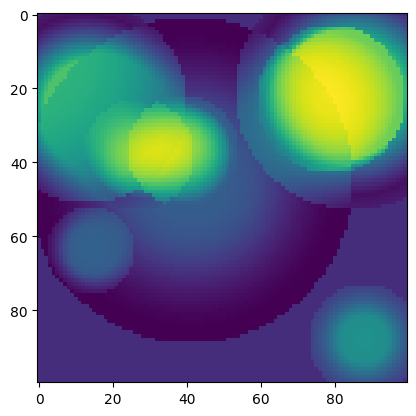

In [4]:
plt.imshow(cube1[:,:,4])

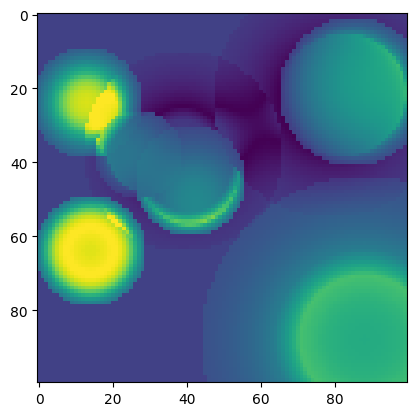

In [5]:
plt.imshow(cube2[:,:,4])

In [6]:
%%time
# ---------------------------------------------------------------------
# 1. load cubes (already background-corrected)
# ---------------------------------------------------------------------
data   = np.load("specs.npz")
cube1  = data["arr_0"].astype(np.float32)           # (Ny, Nx, Ne)
cube2  = data["arr_1"].astype(np.float32)
Ny, Nx, Ne = cube1.shape
outdir = pathlib.Path("outdata")
outdir.mkdir(exist_ok=True, parents=True)

# ---------------------------------------------------------------------
# 2a. cube-1   PCA → UMAP → KMeans
# ---------------------------------------------------------------------
X1_flat       = flatten_cube(cube1)                       # (Npix, Ne)
X1_pca, _     = do_pca(X1_flat, n_comp=30)
emb1, _       = do_umap(X1_pca)
lbl1, _       = do_kmeans(emb1, k=20)
plot_umap(emb1, lbl1, outdir / "c1_umap.png")
plot_cluster_map(lbl1, (Ny, Nx), outdir / "c1_clusters.png")

# ---------------------------------------------------------------------
# 2b. cube-2   PCA → UMAP → KMeans
# ---------------------------------------------------------------------
X2_flat       = flatten_cube(cube2)
X2_pca, _     = do_pca(X2_flat, n_comp=30)
emb2, _       = do_umap(X2_pca)
lbl2, _       = do_kmeans(emb2, k=20)
plot_umap(emb2, lbl2, outdir / "c2_umap.png")
plot_cluster_map(lbl2, (Ny, Nx), outdir / "c2_clusters.png")

# ---------------------------------------------------------------------
# 3. mutual information between the TWO 20-label maps
# ---------------------------------------------------------------------
# global (single value) MI
global_mi = mutual_info_score(lbl1.ravel(), lbl2.ravel())
print(f"Global MI(lbl1,lbl2) = {global_mi:.4f}")

# per-pair MI contribution matrix  (20 × 20)
cont      = contingency_matrix(lbl1.ravel(), lbl2.ravel())  # sklearn 1.4+
N         = cont.sum()
row_sum   = cont.sum(1, keepdims=True)
col_sum   = cont.sum(0, keepdims=True)
with np.errstate(divide='ignore', invalid='ignore'):
    log_term = np.where(cont == 0, 0,
                        np.log( (cont * N) / (row_sum * col_sum) ))
pair_mi   = (cont / N) * log_term          # element-wise
pair_mi[np.isnan(pair_mi)] = 0.0

# 4. top-3 (i,j) pairs by MI contribution
top3 = np.dstack(np.unravel_index(np.argsort(pair_mi, axis=None)[-3:], pair_mi.shape))[0]
for rank, (i, j) in enumerate(top3[::-1], 1):            # largest first
    mask = np.logical_and(lbl1.reshape(Ny,Nx) == i,
                          lbl2.reshape(Ny,Nx) == j)
    plt.figure(figsize=(5,5))
    plt.imshow(mask, cmap="gray")
    plt.title(f"Top-{rank} pair: cube1-{i} & cube2-{j}\nMI contrib = {pair_mi[i,j]:.4e}")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(outdir / f"top{rank}_pair_c1_{i}_c2_{j}.png", dpi=300)
    plt.close()

# 5. save artefacts
np.save(outdir / "cube1_labels.npy", lbl1.reshape(Ny, Nx))
np.save(outdir / "cube2_labels.npy", lbl2.reshape(Ny, Nx))
np.save(outdir / "pair_mi.npy",     pair_mi)
plot_mi_heatmap(pair_mi, outdir)

print(f"Done. Results in {outdir.resolve()}")


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Global MI(lbl1,lbl2) = 0.6319
Done. Results in /content/outdata
CPU times: user 1min 35s, sys: 1.7 s, total: 1min 36s
Wall time: 1min 35s


try installing eelsmapper

In [9]:
# 1. Install (once)
!pip install eelsmapper

In [10]:
# 2. In a Python script / Jupyter notebook
import numpy as np
from eelsmapper.pipeline import run_pipeline  # main helper

# --- load your STEM-EELS cube -----------------
# cube.shape → (rows, cols, energy_channels)
cube = np.load("specs.npz")["arr_0"]

# flatten to (pixels, energy) as expected by the pipeline
X = cube.reshape(-1, cube.shape[-1])

# --- fire the full workflow -------------------
out = run_pipeline(X)

# out is a dict with:
#   out["denoised"]      – PCA-denoised spectra
#   out["embedded"]      – 2-D t-SNE/UMAP coordinates
#   out["clusters"]      – k-means labels
#   out["vq"]            – vector-quantised spectra
#   out["mutual_info"]   – MI matrix between clusters


ModuleNotFoundError: No module named 'eelsmapper.preprocessing'

In [1]:
import eelsmapper
eelsmapper.__dir__()

['__name__',
 '__doc__',
 '__package__',
 '__loader__',
 '__spec__',
 '__path__',
 '__file__',
 '__cached__',
 '__builtins__',
 '__version__']

In [2]:
from eelsmapper.pipeline import run_pipeline

In [5]:
import numpy as np
data = np.load("specs.npz")["arr_0"]
run_pipeline(data.reshape(-1,data.shape[-1]))

{'denoised': array([[ 2.60902411e-15,  2.91838792e-02,  5.91193689e-02, ...,
          9.73259186e-01,  9.87022220e-01,  1.00000000e+00],
        [-2.71449530e-14,  3.09263665e-02,  5.21369986e-02, ...,
          9.70884672e-01,  9.87652073e-01,  1.00000000e+00],
        [-2.96429548e-14,  3.10691898e-02,  5.15646872e-02, ...,
          9.70690044e-01,  9.87703699e-01,  1.00000000e+00],
        ...,
        [ 1.22679644e-14,  4.41823031e-02,  9.11549009e-02, ...,
          9.66265775e-01,  9.84165136e-01,  1.00000000e+00],
        [ 1.07691633e-14,  4.17482250e-02,  8.59558890e-02, ...,
          9.67400728e-01,  9.84628809e-01,  1.00000000e+00],
        [ 2.60902411e-15,  2.91838792e-02,  5.91193689e-02, ...,
          9.73259186e-01,  9.87022220e-01,  1.00000000e+00]]),
 'embedded': array([[ -40.02357 ,   62.694305],
        [-100.776825,  -23.660635],
        [ -99.970085,  -26.090946],
        ...,
        [ -26.140213,   23.32635 ],
        [ -31.677624,   18.88041 ],
        [ -4